In [130]:
## ----------------------------------- bulk RNAseq analysis for yeast ------------------------------ ##

# The data consists of 3 different parts, here we focus only on the 3rd round, meaning 3rd dataset. #

# importing needed packages #
import pandas as pd
import numpy as np
import os
from Bio import SeqIO
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import anndata as ad
import logging

In [131]:
pip install xlrd

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


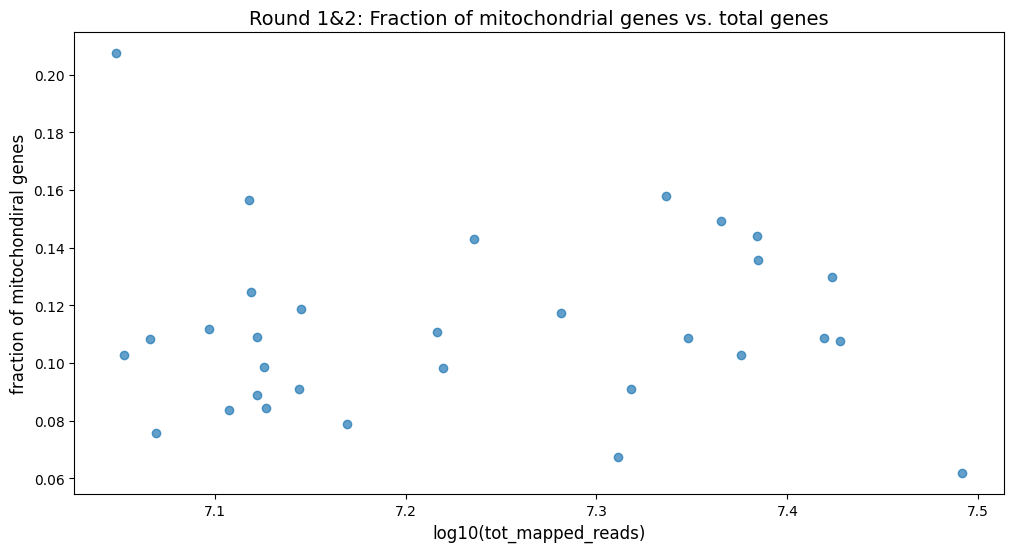

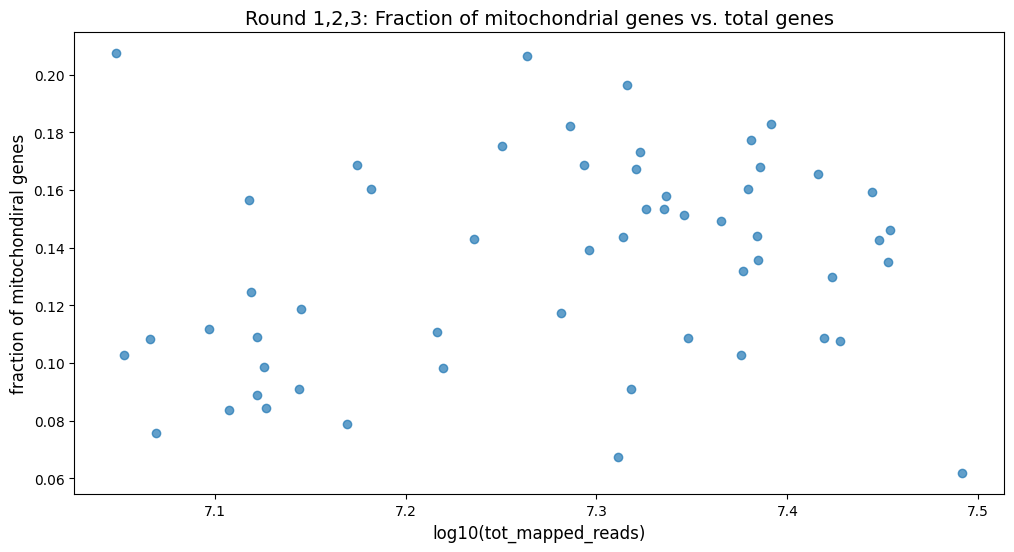

In [136]:
## loading the datasets ##

# filepaths for all three datasets

file_path_1 = "/Users/kimjob/PhD/PhD/RNA_Seq_Novogene/round1/original_data/gene_count.xls" # dataset 1
file_path_2 = "/Users/kimjob/PhD/PhD/RNA_Seq_Novogene/round2/original_data/Gene_Counts.xlsx" # dataset 2
file_path_3 = "/Users/kimjob/PhD/PhD/RNA_Seq_Novogene/round3/gene_count.csv" # dataset 3


# Loading data - I saved the xlsx file for round to as a csv file because I could not read it with the pandas function...
data_1 = pd.read_csv(file_path_1, sep='\t') # CSV file with a semicolon as the separator <-- only this works for correctly uploading the csv file !!
data_2 = pd.read_excel(file_path_2)  
data_3 = pd.read_csv(file_path_3, header=0, sep=";")

Data1 = pd.DataFrame(data_1) 
Data2 = pd.DataFrame(data_2) 
Data3 = pd.DataFrame(data_3) 


# select metadata from all dataframes 

metadata_columns = ['gene_id', 'gene_name', 'gene_chr', 'gene_start', 'gene_end', 
                    'gene_strand', 'gene_length', 'gene_biotype', 'gene_description', 'Family'] 

samples_data1 = [col for col in Data1.columns if col not in metadata_columns]
samples_data2 = [col for col in Data2.columns if col not in metadata_columns]
samples_data3 = [col for col in Data3.columns if col not in metadata_columns]


metadata_data2 = Data2[metadata_columns].drop_duplicates(subset='gene_id') # take the columns from dataset 2, as this dataset has the most genes

# contains only the strains

samples_data1_df = Data1[samples_data1] 
samples_data2_df = Data2[samples_data2]
samples_data3_df = Data3[samples_data3]

samples_data1_df = Data1[['gene_id'] + samples_data1]
samples_data2_df = Data2[['gene_id'] + samples_data2]
samples_data3_df = Data3[['gene_id'] + samples_data3]

# combining first only dataset 1 & 2 to reproduce Vineesh's results #

combined_samples = pd.merge(samples_data1_df, samples_data2_df, on='gene_id', how='outer', suffixes=('_1', '_2')) # suffixes here if there are two times the same column...
combined_data_1_2 = pd.merge(combined_samples, metadata_data2, on='gene_id', how='outer') # combining the dataset1 and 2 + metadata columns

# drop the columns with "AFY25", "AFY55_5" because some biological reason --> they did not see a difference here, so they can be left out
combined_data_1_2.drop(columns=['AFY25_r1','AFY55_5_r1','AFY25_r2','AFY55_5_r2','AFY25_r3','AFY55_5_r3'], inplace=True)


# combining ALL 3 datasets ! #

combined_samples_all =  pd.merge(combined_samples, samples_data3_df, on='gene_id', how='outer')

data_all_rounds = pd.merge(combined_samples_all, metadata_data2, on='gene_id', how='outer') # combining the dataset 1, 2, 3 + metadata columns


# exclude the replicates because of biological reasons: AFY25, AFY55_5

data_all_rounds.drop(columns=['AFY25_r1','AFY55_5_r1','AFY25_r2','AFY55_5_r2','AFY25_r3','AFY55_5_r3'], inplace=True)

### ---------------------------- ROUND 1 + 2 combined -------------------------####

# QC (quality control) ROUND 1&2 data, see how many mitochondiral genes per total mapped reads there are --> reproduce Vineesh's results ##

mit_genes_2 = combined_data_1_2[combined_data_1_2['gene_chr']=='Mito']
metadata_columns_2 = ['gene_id', 'gene_name', 'gene_chr', 'gene_start', 'gene_end', 
                    'gene_strand', 'gene_length', 'gene_biotype', 'gene_description', 'Family'] # additional columns, explaining metadata of samples

sample_columns_2 = [col for col in combined_data_1_2.columns if col not in metadata_columns_2] # all the samples
tot_mapped_reads_2 = combined_data_1_2[sample_columns_2].sum() # takes the sum of all genes per sample

mit_reads_2 =  mit_genes_2[sample_columns_2].sum() # mitochondrial genes
frac_mit_2 = mit_reads_2/tot_mapped_reads_2 # fraction of mitochondrial genes vs total genes

### plotting ###

plt.figure(figsize=(12, 6))
plt.scatter(np.log10(tot_mapped_reads_2), frac_mit_2, alpha=0.7) # take log10 from total reads
plt.title('Round 1&2: Fraction of mitochondrial genes vs. total genes', fontsize=14)
plt.xlabel('log10(tot_mapped_reads)', fontsize=12)
plt.ylabel('fraction of mitochondiral genes', fontsize=12)
plt.show()

### ---------------------------- ALL ROUNDs (1 + 2 + 3) combined -------------------------####


mit_genes = data_all_rounds[data_all_rounds['gene_chr']=='Mito']
metadata_columns = ['gene_id', 'gene_name', 'gene_chr', 'gene_start', 'gene_end', 
                    'gene_strand', 'gene_length', 'gene_biotype', 'gene_description', 'Family'] # additional columns, explaining metadata of samples

sample_columns = [col for col in data_all_rounds.columns if col not in metadata_columns] # all the samples
tot_mapped_reads = data_all_rounds[sample_columns].sum() # takes the sum of all genes per sample

mit_reads=  mit_genes[sample_columns].sum() # mitochondrial genes
frac_mit = mit_reads/tot_mapped_reads # fraction of mitochondrial genes vs total genes

### plotting ###

plt.figure(figsize=(12, 6))
plt.scatter(np.log10(tot_mapped_reads), frac_mit, alpha=0.7) # take log10 from total reads
plt.title('Round 1,2,3: Fraction of mitochondrial genes vs. total genes', fontsize=14)
plt.xlabel('log10(tot_mapped_reads)', fontsize=12)
plt.ylabel('fraction of mitochondiral genes', fontsize=12)
plt.show()



In [137]:
combined_data_1_2.columns

Index(['gene_id', 'ASY20_r1', 'ASY46_r1', 'AFY3_r1', 'MMY116_2c_r1',
       'ASY59_4_r1', 'AFY57_r1', 'ASY20_r2', 'ASY46_r2', 'AFY3_r2',
       'MMY116_2c_r2', 'ASY59_4_r2', 'AFY57_r2', 'ASY20_r3', 'ASY46_r3',
       'AFY3_r3', 'MMY116_2c_r3', 'AFY57_r3', 'ASY20_r4', 'ASY46_r4',
       'AFY3_r4', 'MMY116_2c_r4', 'ASY59_4_r4', 'AFY57_r4', 'ASY20_r5',
       'ASY46_r5', 'AFY3_r5', 'MMY116_2c_r5', 'ASY59_4_r5', 'AFY57_r5',
       'ASY59_4_r6', 'AFY57_r6', 'gene_name', 'gene_chr', 'gene_start',
       'gene_end', 'gene_strand', 'gene_length', 'gene_biotype',
       'gene_description', 'Family'],
      dtype='object')

In [134]:
# check if genes in Dataset 2 match with genes of Dataset 3 or Dataset 1:

gene_ids_data1 = set(Data1['gene_id']) # 7132
gene_ids_data2 = set(Data2['gene_id']) # 7147
gene_ids_data3 = set(Data3['gene_id']) # 7126


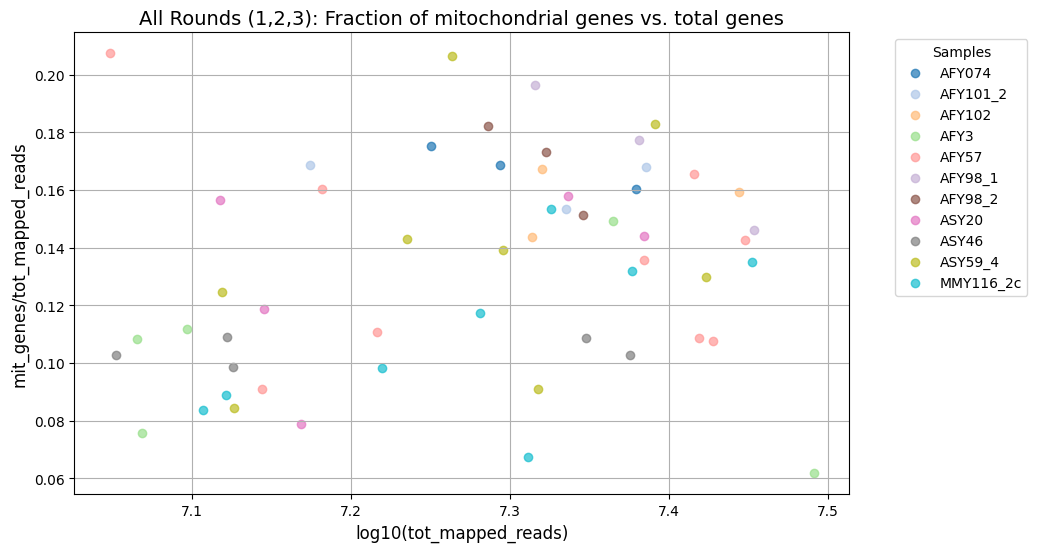

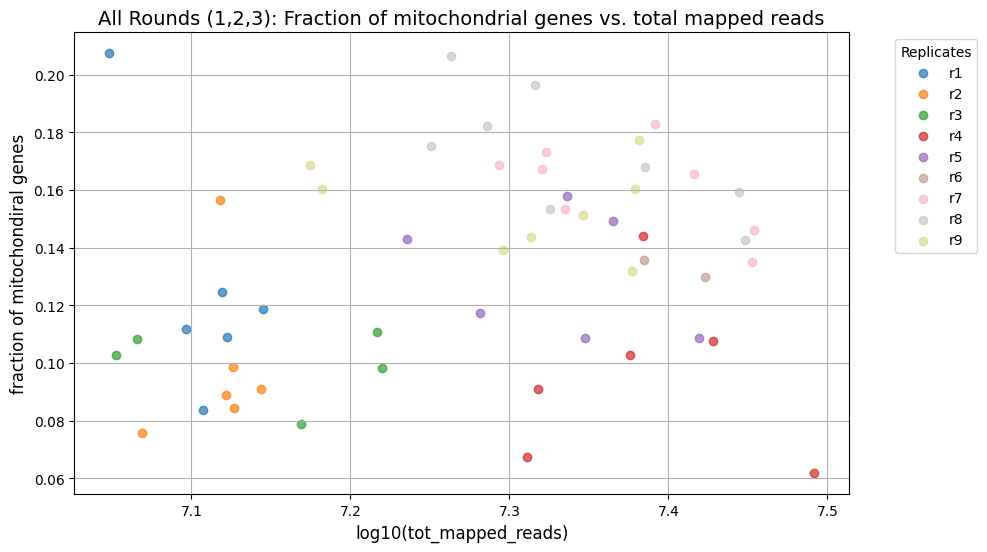

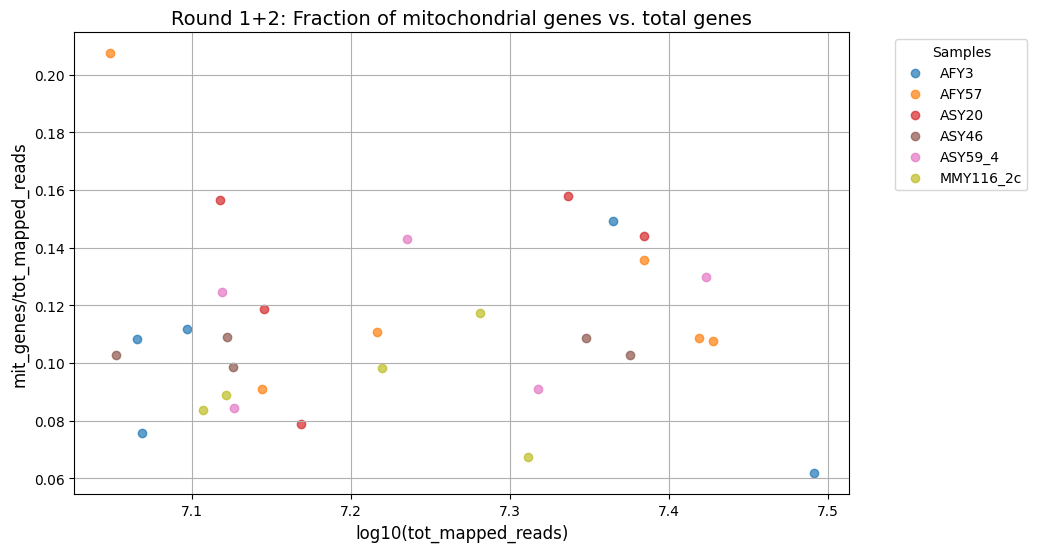

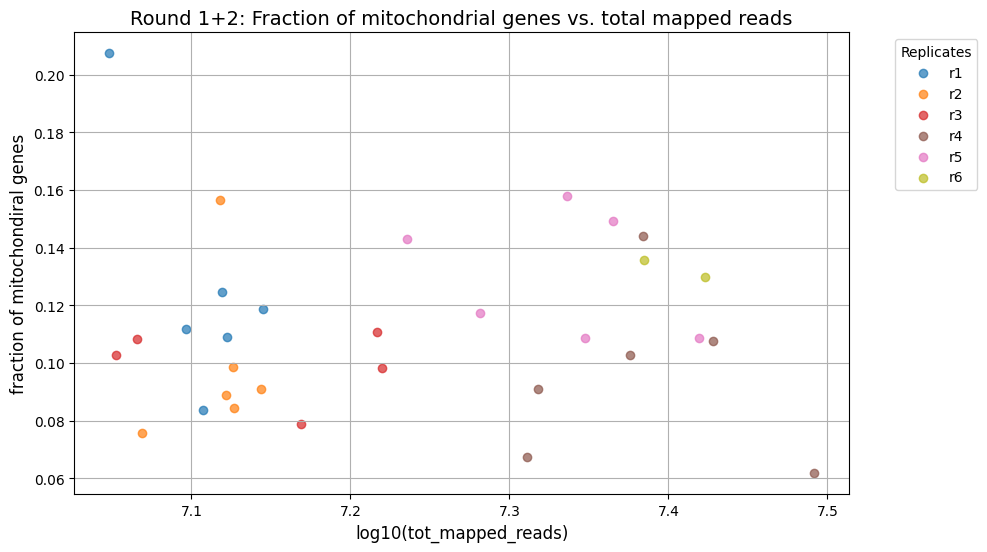

In [138]:

# replicates (1-9)

rep_1 = ["ASY20_r1","ASY46_r1","AFY3_r1","MMY116_2c_r1","ASY59_4_r1","AFY57_r1"]
rep_2 = ["ASY20_r2","ASY46_r2","AFY3_r2","MMY116_2c_r2","ASY59_4_r2","AFY57_r2"]
rep_3 = ["ASY20_r3","ASY46_r3","AFY3_r3","MMY116_2c_r3","AFY57_r3",]
rep_4 = ["ASY20_r4","ASY46_r4","AFY3_r4","MMY116_2c_r4","ASY59_4_r4","AFY57_r4"]
rep_5 = ["ASY20_r5","ASY46_r5","AFY3_r5","MMY116_2c_r5","ASY59_4_r5","AFY57_r5"]
rep_6 = ["ASY59_4_r6","AFY57_r6"]
rep_7 = ["MMY116_2c_r7","ASY59_4_r7","AFY98_1_r7","AFY98_2_r7","AFY57_r7","AFY101_2_r7","AFY102_r7","AFY074_r7"]
rep_8 = ["MMY116_2c_r8","ASY59_4_r8","AFY98_1_r8","AFY98_2_r8","AFY57_r8","AFY101_2_r8","AFY102_r8","AFY074_r8"]
rep_9 = ["MMY116_2c_r9","ASY59_4_r9","AFY98_1_r9","AFY98_2_r9","AFY57_r9","AFY101_2_r9","AFY102_r9","AFY074_r9"]

halpoid = ['ASY20', 'ASY46', 'AFY3']
diploid = ['MMY116','ASY59']


type = [col.split('_r')[0] for col in sample_columns]
replicates = [f"_r{col.split('_r')[1]}" for col in sample_columns] # define replicates in dataset 3

# Create unique color mappings for samples and replicates
unique_samples = sorted(set(type))  # Unique sample names
unique_replicates = sorted(set(replicates))  # Unique replicate IDs

sample_colors = {sample: plt.cm.tab20(i / len(unique_samples)) for i, sample in enumerate(unique_samples)}
replicate_colors = {rep: plt.cm.tab20(i / len(unique_replicates)) for i, rep in enumerate(unique_replicates)}

# Assign colors for each data point
sample_color_map = [sample_colors[sample] for sample in type]
replicate_color_map = [replicate_colors[rep] for rep in replicates]


# plot and color coded according to sample

plt.figure(figsize=(10, 6))
for sample, color in sample_colors.items():
    # Select points for this sample
    indices = [i for i, s in enumerate(type) if s == sample]
    plt.scatter(np.log10(tot_mapped_reads[indices]), frac_mit[indices], alpha=0.7, label=sample, color=color)

#loop for assigning color to sample group
plt.title('All Rounds (1,2,3): Fraction of mitochondrial genes vs. total genes', fontsize=14)
plt.xlabel('log10(tot_mapped_reads)', fontsize=12)
plt.ylabel('mit_genes/tot_mapped_reads', fontsize=12)
plt.legend(title="Samples", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid()
plt.show()


# plot color-coded by replicate
plt.figure(figsize=(10, 6))

for replicate, color in replicate_colors.items():
    # Select points for this replicate
    indices = [i for i, r in enumerate(replicates) if r == replicate]
    x_values = np.log10(tot_mapped_reads[indices])
    y_values = frac_mit[indices]
 
    plt.scatter(np.log10(tot_mapped_reads[indices]), frac_mit[indices], alpha=0.7, label=replicate.split('_')[1], color=color)
        
    '''# Annotate each point with its coordinates
    for x, y in zip(x_values, y_values):
        plt.text(x, y, f'({x:.2f}, {y:.2f})', fontsize=8, ha='right')  # Adjust fontsize and alignment as needed
    '''

plt.title('All Rounds (1,2,3): Fraction of mitochondrial genes vs. total mapped reads', fontsize=14)
plt.xlabel('log10(tot_mapped_reads)', fontsize=12)
plt.ylabel('fraction of mitochondiral genes', fontsize=12)
plt.legend(title="Replicates", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid()
plt.show()


# ------------------------- only Round 1 + 2 to compare with Vineeshs results ------------------------------ #


type_2 = [col.split('_r')[0] for col in sample_columns_2]
replicates_2 = [f"_r{col.split('_r')[1]}" for col in sample_columns_2] # define replicates in dataset 3

# Create unique color mappings for samples and replicates
unique_samples_2 = sorted(set(type_2))  # Unique sample names
unique_replicates_2 = sorted(set(replicates_2))  # Unique replicate IDs

sample_colors_2 = {sample: plt.cm.tab10(i / len(unique_samples_2)) for i, sample in enumerate(unique_samples_2)}
replicate_colors_2 = {rep: plt.cm.tab10(i / len(unique_replicates_2)) for i, rep in enumerate(unique_replicates_2)}

# Assign colors for each data point
sample_color_map = [sample_colors[sample] for sample in type_2]
replicate_color_map = [replicate_colors[rep] for rep in replicates_2]


# plot and color coded according to sample

plt.figure(figsize=(10, 6))
for sample, color in sample_colors_2.items():
    # Select points for this sample
    indices = [i for i, s in enumerate(type_2) if s == sample]
    plt.scatter(np.log10(tot_mapped_reads_2[indices]), frac_mit_2[indices], alpha=0.7, label=sample, color=color)

# loop for assigning color to sample group
plt.title('Round 1+2: Fraction of mitochondrial genes vs. total genes', fontsize=14)
plt.xlabel('log10(tot_mapped_reads)', fontsize=12)
plt.ylabel('mit_genes/tot_mapped_reads', fontsize=12)
plt.legend(title="Samples", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid()
plt.show()


# plot color-coded by replicate
plt.figure(figsize=(10, 6))

for replicate, color in replicate_colors_2.items():
    # Select points for this replicate
    indices = [i for i, r in enumerate(replicates_2) if r == replicate]
    x_values = np.log10(tot_mapped_reads_2[indices])
    y_values = frac_mit_2[indices]
 
    plt.scatter(np.log10(tot_mapped_reads_2[indices]), frac_mit_2[indices], alpha=0.7, label=replicate.split('_')[1], color=color)

plt.title('Round 1+2: Fraction of mitochondrial genes vs. total mapped reads', fontsize=14)
plt.xlabel('log10(tot_mapped_reads)', fontsize=12)
plt.ylabel('fraction of mitochondiral genes', fontsize=12)
plt.legend(title="Replicates", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid()
plt.show()




In [139]:
#print('round 2 fract. mitochondiral genes:',frac_mit_2.sort_values(ascending=True))
print('fract. mitochondiral genes:',frac_mit.sort_values(ascending=True))

fract. mitochondiral genes: AFY3_r4         0.061620
MMY116_2c_r4    0.067410
AFY3_r2         0.075500
ASY20_r3        0.078639
MMY116_2c_r1    0.083812
ASY59_4_r2      0.084335
MMY116_2c_r2    0.088690
AFY57_r2        0.090767
ASY59_4_r4      0.090839
MMY116_2c_r3    0.098188
ASY46_r2        0.098449
ASY46_r3        0.102618
ASY46_r4        0.102745
AFY57_r4        0.107672
AFY3_r3         0.108311
AFY57_r5        0.108745
ASY46_r5        0.108807
ASY46_r1        0.109003
AFY57_r3        0.110583
AFY3_r1         0.111771
MMY116_2c_r5    0.117230
ASY20_r1        0.118704
ASY59_4_r1      0.124776
ASY59_4_r6      0.129776
MMY116_2c_r9    0.132032
MMY116_2c_r7    0.135091
AFY57_r6        0.135595
ASY59_4_r9      0.139025
AFY57_r8        0.142574
ASY59_4_r5      0.142962
AFY102_r9       0.143837
ASY20_r4        0.144201
AFY98_1_r7      0.146265
AFY3_r5         0.149339
AFY98_2_r9      0.151241
AFY101_2_r7     0.153405
MMY116_2c_r8    0.153481
ASY20_r2        0.156704
ASY20_r5        0.1580

df_sorted:           Sample  Mito_Genes               Group
54     AFY074_r9    0.160220  2x triple addition
31  MMY116_2c_r7    0.135091  2x triple addition
15  MMY116_2c_r3    0.098188  2x triple addition
38     AFY074_r7    0.168587  2x triple addition
39  MMY116_2c_r8    0.153481  2x triple addition
26  MMY116_2c_r5    0.117230  2x triple addition
9   MMY116_2c_r2    0.088690  2x triple addition
20  MMY116_2c_r4    0.067410  2x triple addition
46     AFY074_r8    0.175299  2x triple addition
47  MMY116_2c_r9    0.132032  2x triple addition
3   MMY116_2c_r1    0.083812  2x triple addition
41    AFY98_1_r8    0.196612     double addition
48    ASY59_4_r9    0.139025     double addition
34    AFY98_2_r7    0.173367     double addition
33    AFY98_1_r7    0.146265     double addition
49    AFY98_1_r9    0.177452     double addition
32    ASY59_4_r7    0.182936     double addition
50    AFY98_2_r9    0.151241     double addition
29    ASY59_4_r6    0.129776     double addition
42    AFY

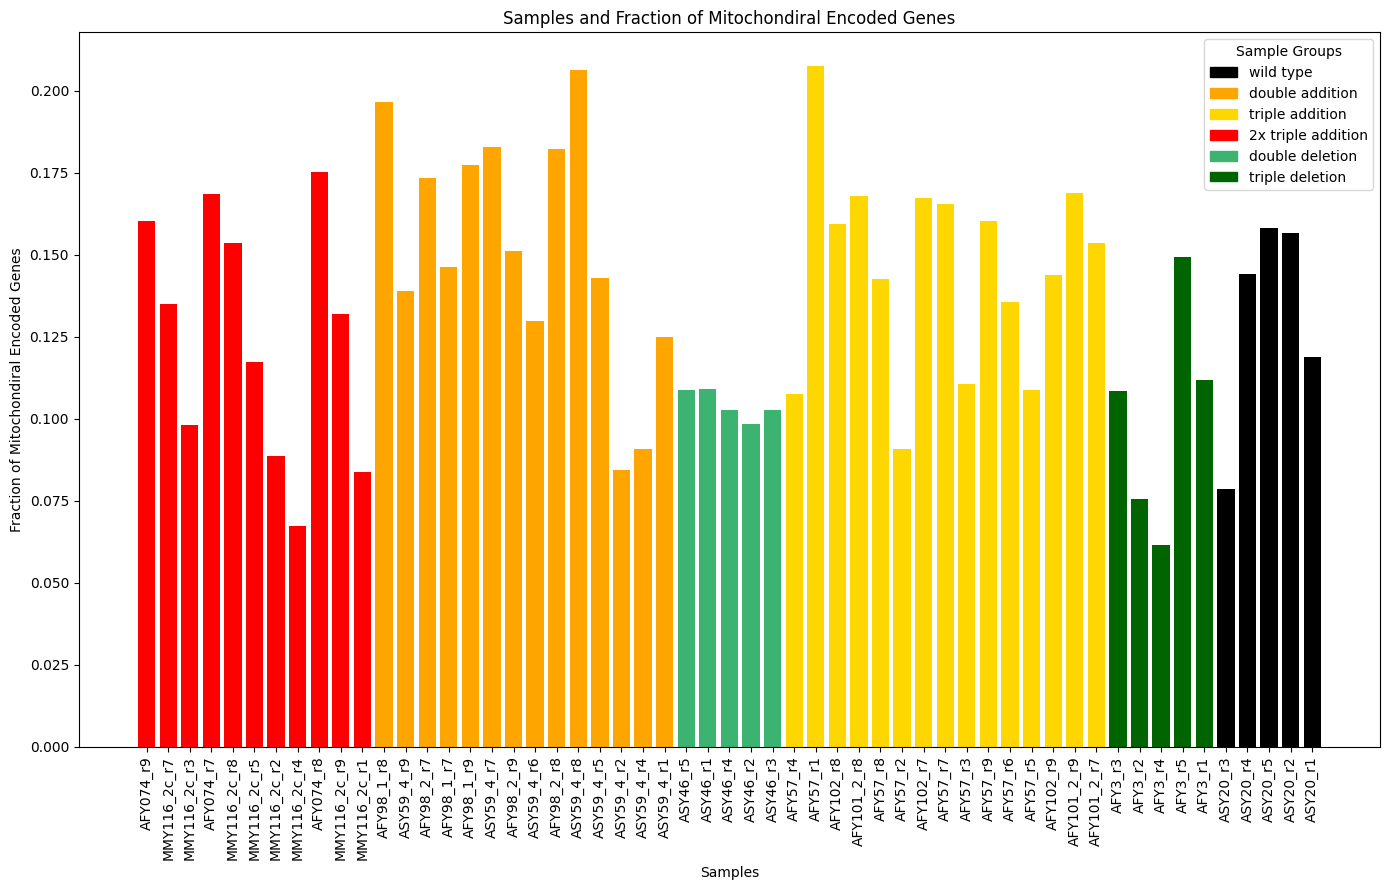

In [149]:
## create plot to see fraction of mitochondrial content per sample ##

#create list of mitochondrial genes 
mito_genes = []
for i in frac_mit.values:
    mito_genes.append(i)

# different samples grouped

# halpoids (one strand)
W_T = ['MMY116_']
double_addition = ['ASY59','AFY98_1', 'AFY98_2']
triple_addition = ['AFY57','AFY101_2','AFY102']
triple_addition_2 = ['AFY74']

# diploid (souble strands)
W_T = ['ASY20']
double_deletion = ['ASY46']
triple_deletion = ['AFY3']


group_colors = {
    'wild type': 'k',
    'double addition': 'orange',
    'triple addition': 'gold',
    '2x triple addition': 'red',
    'double deletion': 'mediumseagreen',
    'triple deletion': 'darkgreen'
}

group_types = []

# assigning type to group

for sample in sample_columns:
    if sample.startswith(tuple(W_T)):
        group_types.append('wild type')
    elif sample.startswith(tuple(double_addition)):
        group_types.append('double addition')
    elif sample.startswith(tuple(triple_addition)):
        group_types.append('triple addition')
    elif sample.startswith(tuple(double_deletion)):
        group_types.append('double deletion')
    elif sample.startswith(tuple(triple_deletion)):
        group_types.append('triple deletion')
    else:
        group_types.append('2x triple addition')
   
data = {
    'Sample': sample_columns,
    'Mito_Genes': mito_genes,
    'Group': group_types
}
df = pd.DataFrame(data)

df_sorted = df.sort_values(by='Group') #dataframe sorted by group

print('df_sorted:',df_sorted)

bar_colors = [group_colors[group] for group in df_sorted['Group']]

plt.figure(figsize=(14, 9))
bars = plt.bar(df_sorted['Sample'], df_sorted['Mito_Genes'], color=bar_colors)
plt.xlabel('Samples')
plt.title('Samples and Fraction of Mitochondiral Encoded Genes')
plt.xticks(rotation=90)
plt.ylabel('Fraction of Mitochondiral Encoded Genes')


handles = [plt.Rectangle((0,0),1,1, color=group_colors[group]) for group in group_colors]
plt.legend(handles, group_colors.keys(), title="Sample Groups")

plt.tight_layout()  # Adjust layout to make room for tilted labels
plt.show()


In [ ]:
test_extreme = df_genes[((df_genes.drop(columns=['gene_length']) >= 200000).sum(axis=1) >= 24)]

test_extreme

In [ ]:


df_genes = Data3[['gene_id'] + sample_columns_3 + ['gene_length']] # Dataframe containing genes + gene length

# filter out genes that don't fulfill criteria: Keep genes with counts > 30 in at least 3 samples

df_genes.set_index('gene_id', inplace=True)

# keep genes that have more than 30 counts in at least 3 samples, for this do not include "gene_length"
filtered_genes = df_genes[((df_genes.drop(columns=['gene_length']) >= 30).sum(axis=1) >= 3)]
filtered_genes

# example for gene "YOR225W" --> at least 3x the count 30 
"""MMY116_2c_r7     55
ASY59_4_r7       25
AFY98_1_r7       30
AFY98_2_r7       23
AFY57_r7          6
AFY101_2_r7      13
AFY102_r7        11
AFY074_r7         2
MMY116_2c_r8     33
ASY59_4_r8       17
AFY98_1_r8       11
AFY98_2_r8       23
AFY57_r8         20
AFY101_2_r8      13
AFY102_r8         2
AFY074_r8        11
MMY116_2c_r9     19
ASY59_4_r9       19
AFY98_1_r9       32
AFY98_2_r9       20
AFY57_r9          2
AFY101_2_r9       3
AFY102_r9        10
AFY074_r9         7
gene_length     330
Name: YOR225W, dtype: int64"""

In [ ]:
filtered_genes.loc['YOR225W']

In [ ]:
## TPM normalization ##

def read_counts2tpm_(df):
    ## convert read counts to TPM (transcripts per million) ##
    
    result = df.copy()  # create copy otherwise sample/gene names get lost
    sample_reads = result.loc[:, result.columns != 'gene_length'].copy()  # Exclude gene_length
    gene_len = result['gene_length'].values  # Extract gene lengths as a numpy array

    gene_len = pd.to_numeric(gene_len, errors='coerce') # needs to be numeric otherwise error appears

    print('gene_length:', gene_len)

    # Normalize by gene length
    
    normalize_by_genelength = sample_reads.values  * 1e3 / gene_len[:, np.newaxis]  # multiplication by 1e3 comes because (onverting to kb)
    
    print('normalize by gene length:', normalize_by_genelength)

    scaling_factor = (np.sum(normalize_by_genelength, axis=0).reshape(1, -1)) / 1e6  # Scaling factor
    print('scaling factor:', scaling_factor)
    tpm = normalize_by_genelength / scaling_factor  # Normalize sequencing depth

    tpm_df = pd.DataFrame(tpm, columns=sample_reads.columns, index=sample_reads.index)
    tpm_df["gene_length"] = result["gene_length"]

    return tpm_df


TPM_MasterCount = pd.DataFrame(read_counts2tpm_(filtered_genes))

#check if normalization is correct
print('is normalization correct:')
TPM_MasterCount.sum(axis = 0, skipna = True)

In [ ]:
## final count matrix --> tpm normalized ! #
 
TPM_MasterCount

In [ ]:
TPM_MasterCount.iloc[:,1:24]

In [ ]:
# calculate mean expression of genes in samples

#not normalized
filtered_genes['gene_mean'] = filtered_genes.iloc[:,1:24].mean(axis=1)


#normalized
TPM_MasterCount['gene_mean'] = TPM_MasterCount.iloc[:,1:24].mean(axis=1)

TPM_MasterCount


In [ ]:
#normalized

plt.figure(figsize=(10,8))
plt.scatter(y=filtered_genes['gene_mean'], x=filtered_genes['gene_length'], color='k', marker='.')
plt.title('non-normalized counts')
plt.xlabel('gene length')
plt.ylabel('mean gene count')
plt.legend()

#not normalized
plt.figure(figsize=(10,8))
plt.scatter(y=TPM_MasterCount['gene_mean'], x=filtered_genes['gene_length'], color='k', marker='.')
plt.title('normalized counts')
plt.xlabel('gene length')
plt.ylabel('mean gene count')
plt.legend()

In [ ]:
TPM_MasterCount

In [12]:
TPM_MasterCount.drop(columns=['gene_mean', 'gene_length'], inplace=True)

In [ ]:
# PCA analysis #

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#transform the dataframe such that it can be used with the log-function

TPM_count_log = TPM_MasterCount.copy()
count_original_log = filtered_genes.copy()

TPM_count_log = np.log10(TPM_MasterCount + 1)
count_original_log = np.log10(filtered_genes + 1)

TPM_count_log = TPM_count_log.T

print('TPM_count_log:', TPM_count_log)


# creating Anndata #
X = TPM_count_log.values
obs = pd.DataFrame(index=TPM_count_log.index)
var = pd.DataFrame(index=TPM_count_log.columns) 

adata = ad.AnnData(X=X, obs=obs, var=var)

print('adata.obs:',adata.obs) # check if the Anndata is constructed correctly and that you find here the samples


In [ ]:
TPM_count_log['YOR329W-A']

In [ ]:
#### PCA analysis ####

# do PCA with highly variable genes as features #

# defining highly variable genes via scanpy #
sc.pp.highly_variable_genes(adata,n_top_genes=500, flavor='seurat', inplace=True)


adata_hvg = adata[:, adata.var['highly_variable']].copy() #new data

# PCA
sc.pp.pca(adata_hvg, n_comps=23)

pca_coordinates = adata_hvg.obsm['X_pca']
#pca_loadings = adata_hvg.uns['pca']['components']
explained_variance = adata_hvg.uns['pca']['variance']
explained_variance_ratio = adata_hvg.uns['pca']['variance_ratio']
adata_hvg.uns['pca']

# create function, by variance to select highly variable genes, somehow I get better results with this approach #
"""
def select_HVG(df, num_genes=500):
    
    gene_variance = df.var(axis=1)
    top_genes = gene_variance.nlargest(num_genes).index

    return df.loc[top_genes]

highly_variable_genes = select_HVG(TPM_MasterCount, num_genes=500)"""

# check if there are stored HVG (from scanpy packages) ---> probably don't have to do this again if commented out above, but run the code again to make sure !!!
"""
adata.var["highly_variable"] = False  
adata.var.loc[highly_variable_genes.index, "highly_variable"] = True
adata.uns["hvg"] = highly_variable_genes.index.tolist()
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
"""
sc.pp.pca(adata_hvg, n_comps=23)

pca_coordinates = adata_hvg.obsm['X_pca']
#pca_loadings = adata_hvg.uns['pca']['components']
explained_variance = adata_hvg.uns['pca']['variance']
explained_variance_ratio = adata_hvg.uns['pca']['variance_ratio']
adata_hvg.uns['pca']


pca1 = pca_coordinates[:,0]
pca2 = pca_coordinates[:,1]
pca3 =  pca_coordinates[:,2]
pca4 = pca_coordinates[:,3]

cum_sum_eigenvalues = np.cumsum(explained_variance_ratio) # to choose the number of PCA components
n_min = np.argmax(cum_sum_eigenvalues>0.99)
n_min

print('explained variance:',explained_variance)
print('explained_variance_ratio:',explained_variance_ratio)
print('cum sum eigenvalues:', cum_sum_eigenvalues)


In [ ]:
# plotting elbow plot to check how many pca components are needed # 

fig, ax = plt.subplots(figsize=(11, 5) )
plt.plot(np.cumsum(explained_variance_ratio), linewidth=2)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(x = n_min, color = 'r', label = '99% of explained variance')
plt.legend()
plt.grid();

In [ ]:
# color the pca component according to the replicates and also mutations

mutation_group = df_sorted[['Sample', 'Group']]

sample_group = []
for i in mutation_group['Group'].values:
    sample_group.append(i)

mutation_group


In [ ]:
print('pca1:',pca1)
print('pca2:',pca2)
print('sample_columns_3:',sample_columns_3)

In [ ]:
adata_hvg

In [ ]:
adata_hvg.obs

In [ ]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Sample metadata (replace with actual DataFrame if loaded from a file)
metadata = pd.DataFrame({
    "Sample": [
        "AFY074_r9", "AFY074_r8", "AFY074_r7", "AFY98_2_r9", "AFY98_1_r9", "ASY59_4_r9",
        "AFY98_1_r8", "ASY59_4_r8", "AFY98_2_r8", "AFY98_2_r7", "AFY98_1_r7", "ASY59_4_r7",
        "AFY102_r7", "AFY101_2_r7", "AFY102_r9", "AFY57_r8", "AFY101_2_r8", "AFY102_r8",
        "AFY57_r7", "AFY57_r9", "AFY101_2_r9", "MMY116_2c_r9", "MMY116_2c_r8", "MMY116_2c_r7"
    ],
    "Group": [
        "2x triple addition", "2x triple addition", "2x triple addition", "double addition",
        "double addition", "double addition", "double addition", "double addition", "double addition",
        "double addition", "double addition", "double addition", "triple addition", "triple addition",
        "triple addition", "triple addition", "triple addition", "triple addition", "triple addition",
        "triple addition", "triple addition", "wild type", "wild type", "wild type"
    ]

})


metadata.set_index("Sample", inplace=True)

adata_hvg.obs = adata_hvg.obs.join(metadata, how="left")

# Extract replicate info (r7, r8, r9) from sample names ---> change of course for spec
adata_hvg.obs["Replicate"] = adata_hvg.obs.index.to_series().str.extract(r"_(r\d+)")[0]
adata_hvg.obs



In [ ]:
# plotting #

# component 1 vs component 2 

#coloring all samples

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca1,  # PC1
    y=pca2,  # PC2
    hue=adata_hvg.obs.index,  # Color by Sample
    palette="tab20",  # Color palette
    alpha=0.8  # Transparency
)
plt.xlabel(f"PC1 component: ({explained_variance_ratio[0]:.2%})")
plt.ylabel(f"PC2 component: ({explained_variance_ratio[1]:.2%})")
plt.title("PCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()
plt.show()

# coloring according to mutation group and samples

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca1,  # PC1
    y=pca2,  # PC2
    hue=adata_hvg.obs["Group"],  # Color by Group
    style=adata_hvg.obs["Replicate"], 
    palette="Set2",  # Distinct colors for groups
    alpha=0.8
)
plt.xlabel(f"PC1 component: ({explained_variance_ratio[0]:.2%})")
plt.ylabel(f"PC2 component: ({explained_variance_ratio[1]:.2%})")
plt.title("PCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()
plt.show()


# component 2 vs component 3

print('PCA analysis component 2 and 3')

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca2,  # PC2
    y=pca3,  # PC3
    hue=adata_hvg.obs.index,  # Color by Sample
    palette="tab20",  # Color palette
    alpha=0.8  # Transparency
)
plt.xlabel(f"PC2 component: ({explained_variance_ratio[1]:.2%})")
plt.ylabel(f"PC3 component: ({explained_variance_ratio[2]:.2%})")
plt.title("PCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()
plt.show()


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca3,  # PC2
    y=pca4,  # PC3
    hue=adata_hvg.obs["Group"],  # Color by Group
    style=adata_hvg.obs["Replicate"],  
    palette="Set2",  # Distinct colors for groups
    alpha=0.8
)
plt.xlabel(f"PC2 component: ({explained_variance_ratio[1]:.2%})")
plt.ylabel(f"PC3 component: ({explained_variance_ratio[2]:.2%})")
plt.title("PCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()
plt.show()


In [24]:
##### ---------------------------------- DE genes analysis ---------------------------------- #####

### Using pyDESEq2 ---> This package is a python implementation of the DESeq2 method [LHA14]
#  for differential expression analysis (DEA) 
# with bulk RNA-seq data, originally in R. It aims to facilitate DEA experiments for python users. ###

# removing genes with very low counts...

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


In [ ]:
!pip install pydeseq2 # issues to install in terminal, so installing directly in juüyter notebook

In [25]:
count = filtered_genes.drop(columns=['gene_length', 'gene_mean'])

In [26]:
counts = count.T # genes need to be the columns and samples the rows

In [ ]:
counts

In [28]:
metadata = pd.DataFrame(zip(counts.index, ['WT', 'double_addition', 'double_addition', 'double_addition', 'triple_addition', 'triple_addition','triple_addition', '2x_triple_addition', 'WT', 'double_addition', 'double_addition', 'double_addition', 'triple_addition', 'triple_addition','triple_addition', '2x_triple_addition','WT', 'double_addition', 'double_addition', 'double_addition', 'triple_addition', 'triple_addition','triple_addition', '2x_triple_addition'], ['r7', 'r7', 'r7', 'r7', 'r7', 'r7', 'r7', 'r7', 'r8', 'r8', 'r8','r8', 'r8', 'r8', 'r8','r8', 'r9', 'r9', 'r9', 'r9', 'r9', 'r9', 'r9', 'r9']), columns = ['Sample', 'Condition', 'Replicate'])

In [ ]:
metadata.columns

In [ ]:
metadata

In [31]:
metadata = metadata.set_index('Sample')

In [ ]:
metadata

In [ ]:
dds.obs

In [ ]:
# having now the count table (counts) and metadata (metadata) table we can do differential expression

from pydeseq2.dds import DeseqDataSet

# ordering the metadataConditions column such that the control group is the first: Here = WT.

metadata['Condition'] = pd.Categorical(metadata['Condition'],
                                       categories=["WT", "double_addition", "triple_addition", "2x_triple_addition"],
                                       ordered=True)
# creating DeseqDataSet object

dds = DeseqDataSet(counts=counts,
             metadata=metadata,
             design_factors=["Replicate","Condition"])


dds.deseq2()


In [ ]:
dds.obs['Condition']

In [ ]:
#stat_res = DeseqStats(dds, contrast = ('Condition','XX','YY'))   

stat_res_double_addition = DeseqStats(dds, contrast=('Condition', 'WT', 'double-addition')) # comparing double addition with wild-type
stat_res_double_addition.summary()

stat_res_triple_addition = DeseqStats(dds, contrast = ('Condition', 'WT', 'triple-addition')) # comparing triple addition with wild-type
stat_res_triple_addition.summary()

stat_res_2x_triple_addition = DeseqStats(dds, contrast = ('Condition', 'WT', '2x-triple-addition')) # comparing 2x triple addition with wild-type
stat_res_2x_triple_addition.summary()

In [44]:
res_double_addition = stat_res_double_addition.results_df

res_triple_addition = stat_res_triple_addition.results_df

res_2x_triple_addition = stat_res_2x_triple_addition.results_df


In [ ]:
res_2x_triple_addition['log2FoldChange'].sort_values() # check the outliers

In [ ]:
outlier_YOR329W_A = Data3[Data3['gene_id']== 'YOR329W-A']

outlier_YOR329W_A.max()

In [ ]:
# there appears to be a conflict with matplotlib version: 'ColormapRegistry' object has no attribute 'get_cmap'. 
#  

pip install matplotlib==3.6.2 


In [ ]:
# create again pca ... ? just following the tutorial here

import scanpy as sc

sc.tl.pca(dds)

sc.pl.pca(dds, color='Condition', size=200) # this is so bad ?! ...........

In [ ]:
# downstream analysis ----> need to install this somehow. Or maye

dds

In [ ]:
# plotting the results

plt.figure(figsize=(8,6))

plt.scatter(np.log10(res_double_addition['baseMean'] +1), res_double_addition['log2FoldChange'], color='gray', alpha=0.5, s=10, label='All genes')

#adding significant genes with padj < 0.1 as blue scatterdots
sig = res_double_addition['padj'] < 0.1
plt.scatter(np.log10(res_double_addition.loc[sig,'baseMean'] + 1),
            res_double_addition.loc[sig,'log2FoldChange'],
            color='blue', alpha=0.7, s=10, label='padj < 0.1')

plt.xlabel('log10(baseMean)')
plt.ylabel('log2 fold change')
plt.title('Double Addition vs. WT')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))

plt.scatter(np.log10(res_triple_addition['baseMean'] +1), res_triple_addition['log2FoldChange'], color='gray', alpha=0.5, s=10, label='All genes')

#adding significant genes with padj < 0.1 as blue scatterdots
sig = res_double_addition['padj'] < 0.1
plt.scatter(np.log10(res_triple_addition.loc[sig,'baseMean'] + 1),
            res_triple_addition.loc[sig,'log2FoldChange'],
            color='blue', alpha=0.7, s=10, label='padj < 0.1')

plt.xlabel('log10(baseMean)')
plt.ylabel('log2 fold change')
plt.title('Triple Addition vs. WT')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))

plt.scatter(np.log10(res_2x_triple_addition['baseMean'] +1), res_2x_triple_addition['log2FoldChange'], color='gray', alpha=0.5, s=10, label='All genes')

#adding significant genes with padj < 0.1 as blue scatterdots
sig = res_2x_triple_addition['padj'] < 0.1
plt.scatter(np.log10(res_2x_triple_addition.loc[sig,'baseMean'] + 1),
            res_2x_triple_addition.loc[sig,'log2FoldChange'],
            color='blue', alpha=0.7, s=10, label='padj < 0.1')

plt.xlabel('log10(baseMean)')
plt.ylabel('log2 fold change')
plt.title('2x Triple Addition vs. WT')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()